In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pyspark

In [3]:
sales_data = pd.read_csv('/Users/tobias/Downloads/sales.csv.txt', error_bad_lines=False)

/var/folders/51/p_9jxbq11457y302b6d7fk4w0000gn/T/ipykernel_53336/3037791132.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sales_data = pd.read_csv('/Users/tobias/Downloads/sales.csv.txt', error_bad_lines=False)
Skipping line 17: expected 5 fields, saw 6
Skipping line 56: expected 5 fields, saw 6
Skipping line 95: expected 5 fields, saw 6



In [4]:
sales_data.head()

,1,A,2023-01-01,India,Swiggy
0,2,A,2022-01-01,India,Swiggy
1,2,A,2023-01-07,India,Swiggy
2,3,A,2023-01-10,India,Restaurant
3,3,A,2022-01-11,India,Swiggy
4,3,A,2023-01-11,India,Restaurant


In [5]:
menu_data = pd.read_csv('/Users/tobias/Downloads/menu.csv.txt')

In [6]:
menu_data.head()

,1,PIZZA,100,Unnamed: 3
0,2,Chowmin,150,NaN
1,3,sandwich,120,NaN
2,4,Dosa,110,NaN
3,5,Biryani,80,NaN
4,6,Pasta,180,NaN


## Creating a Dataframe for Sales

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

# Initialize a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

schema = StructType([
    StructField('product_id', IntegerType(), True),
    StructField('customer_id', StringType(), True),
    StructField('order_date', DateType(), True),  
    StructField('location', StringType(), True),     
    StructField('source_order', StringType(), True),
])


In [9]:
sales_df = spark.read.format('csv').option('inferSchema', 'true').schema(schema).load('/Users/tobias/Downloads/sales.csv.txt')

In [10]:
sales_df.show()

+----------+-----------+----------+--------+------------+
|product_id|customer_id|order_date|location|source_order|
+----------+-----------+----------+--------+------------+
|         1|          A|2023-01-01|   India|      Swiggy|
|         2|          A|2022-01-01|   India|      Swiggy|
|         2|          A|2023-01-07|   India|      Swiggy|
|         3|          A|2023-01-10|   India|  Restaurant|
|         3|          A|2022-01-11|   India|      Swiggy|
|         3|          A|2023-01-11|   India|  Restaurant|
|         2|          B|2022-02-01|   India|      Swiggy|
|         2|          B|2023-01-02|   India|      Swiggy|
|         1|          B|2023-01-04|   India|  Restaurant|
|         1|          B|2023-02-11|   India|      Swiggy|
|         3|          B|2023-01-16|   India|      zomato|
|         3|          B|2022-02-01|   India|      zomato|
|         3|          C|2023-01-01|   India|      zomato|
|         1|          C|2023-01-01|      UK|      Swiggy|
|         6|  

In [11]:
from pyspark.sql.functions import year, quarter, month

In [12]:
sales_df=sales_df.withColumn('order_year',year(sales_df.order_date))
sales_df=sales_df.withColumn('order_quarter',quarter(sales_df.order_date))
sales_df=sales_df.withColumn('order_month',month(sales_df.order_date))

In [13]:
sales_df.show()

+----------+-----------+----------+--------+------------+----------+-------------+-----------+
|product_id|customer_id|order_date|location|source_order|order_year|order_quarter|order_month|
+----------+-----------+----------+--------+------------+----------+-------------+-----------+
|         1|          A|2023-01-01|   India|      Swiggy|      2023|            1|          1|
|         2|          A|2022-01-01|   India|      Swiggy|      2022|            1|          1|
|         2|          A|2023-01-07|   India|      Swiggy|      2023|            1|          1|
|         3|          A|2023-01-10|   India|  Restaurant|      2023|            1|          1|
|         3|          A|2022-01-11|   India|      Swiggy|      2022|            1|          1|
|         3|          A|2023-01-11|   India|  Restaurant|      2023|            1|          1|
|         2|          B|2022-02-01|   India|      Swiggy|      2022|            1|          2|
|         2|          B|2023-01-02|   India|      

## Creating a DataFrame for Menu

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType


schema = StructType([
    StructField('product_id', IntegerType(), True),
    StructField('product_name', StringType(), True),
    StructField('price', FloatType(), True),
])

In [15]:
menu_df = spark.read.format('csv').option('inferSchema', 'true').schema(schema).load('/Users/tobias/Downloads/menu.csv.txt')

In [16]:
menu_df.show()

+----------+------------+-----+
|product_id|product_name|price|
+----------+------------+-----+
|         1|       PIZZA|100.0|
|         2|     Chowmin|150.0|
|         3|    sandwich|120.0|
|         4|        Dosa|110.0|
|         5|     Biryani| 80.0|
|         6|       Pasta|180.0|
+----------+------------+-----+



## Deriving KPIs from Tables 

In [17]:
from pyspark.sql.functions import sum

In [18]:
## Total Amount Spent by each customer
total_amount_spent= (sales_df.join(menu_df, 'product_id')).groupby('customer_id').agg(sum('price').alias('total_amount_spent')).orderBy('customer_id')
total_amount_spent.show()

+-----------+------------------+
|customer_id|total_amount_spent|
+-----------+------------------+
|          A|            4260.0|
|          B|            4440.0|
|          C|            2400.0|
|          D|            1200.0|
|          E|            2040.0|
+-----------+------------------+



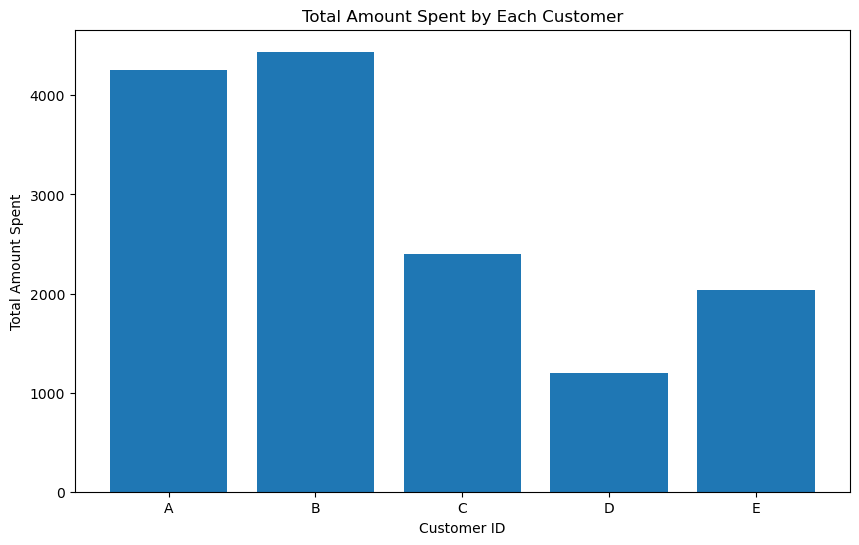

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
total_amount_spent_pd = total_amount_spent.toPandas()

# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(total_amount_spent_pd['customer_id'], total_amount_spent_pd['total_amount_spent'])
plt.xlabel('Customer ID')
plt.ylabel('Total Amount Spent')
plt.title('Total Amount Spent by Each Customer')

# Show the chart
plt.show()

In [20]:
## Total Amount Spent by each food category
total_amount_spent= (sales_df.join(menu_df, 'product_id')).groupby('product_name').agg(sum('price').alias('total_amount_spent')).orderBy('product_name')
total_amount_spent.show()

+------------+------------------+
|product_name|total_amount_spent|
+------------+------------------+
|     Biryani|             480.0|
|     Chowmin|            3600.0|
|        Dosa|            1320.0|
|       PIZZA|            2100.0|
|       Pasta|            1080.0|
|    sandwich|            5760.0|
+------------+------------------+



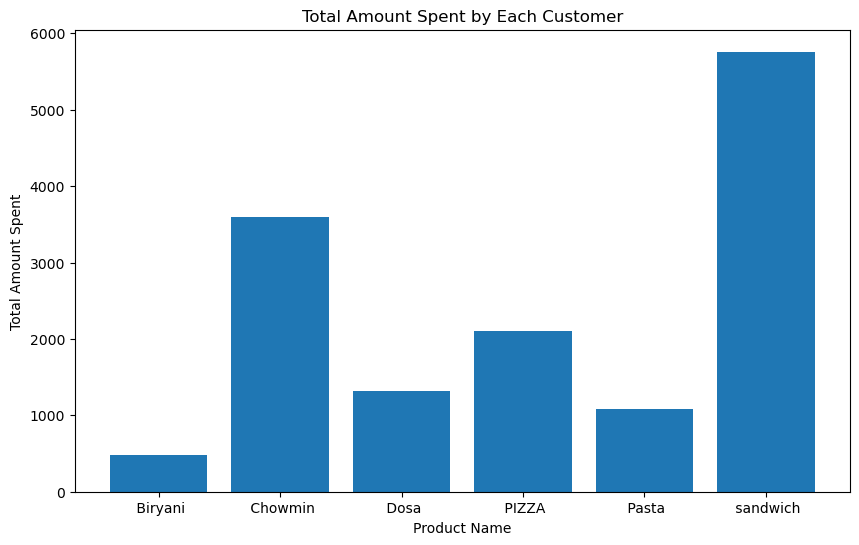

In [23]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
total_amount_spent_pd = total_amount_spent.toPandas()

# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(total_amount_spent_pd['product_name'], total_amount_spent_pd['total_amount_spent'])
plt.xlabel('Product Name')
plt.ylabel('Total Amount Spent')
plt.title('Total Amount Spent by Each Customer')

# Show the chart
plt.show()

In [28]:
## Total Amount of Sales in each Month
Total_amount_sales = (sales_df.join(menu_df, 'product_id')).groupby('Order_month').agg(sum('price').alias('Total_amount_sales'))
Total_amount_sales.show()

+-----------+------------------+
|Order_month|Total_amount_sales|
+-----------+------------------+
|          1|            2960.0|
|          6|            2960.0|
|          3|             910.0|
|          5|            2960.0|
|          7|             910.0|
|         11|             910.0|
|          2|            2730.0|
+-----------+------------------+



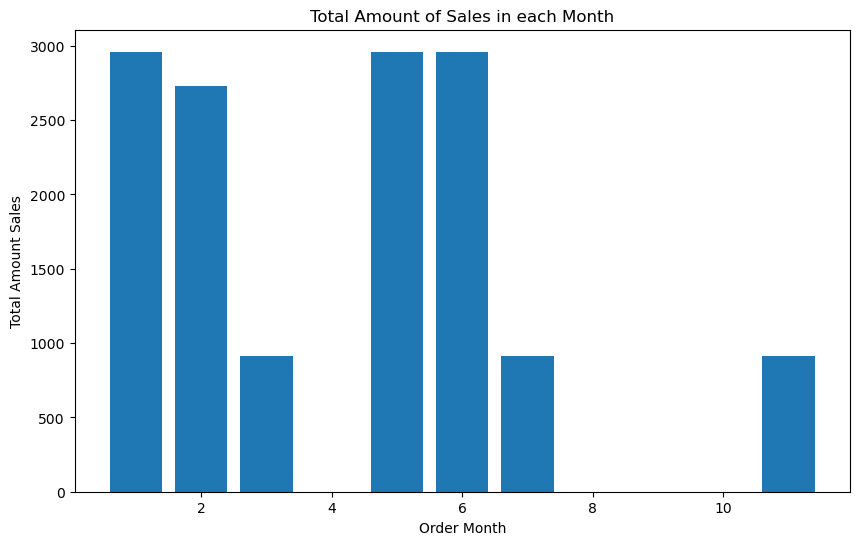

In [31]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
total_amount_sales_pd = Total_amount_sales.toPandas()

# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(total_amount_sales_pd['Order_month'], total_amount_sales_pd['Total_amount_sales'])
plt.xlabel('Order Month')
plt.ylabel('Total Amount Sales')
plt.title('Total Amount of Sales in each Month')

# Show the chart
plt.show()

In [32]:
## Total Amount of Sales in each Year
Total_amount_sales = (sales_df.join(menu_df, 'product_id')).groupby('Order_year').agg(sum('price').alias('Total_amount_sales'))
Total_amount_sales.show()

+----------+------------------+
|Order_year|Total_amount_sales|
+----------+------------------+
|      2023|            9990.0|
|      2022|            4350.0|
+----------+------------------+



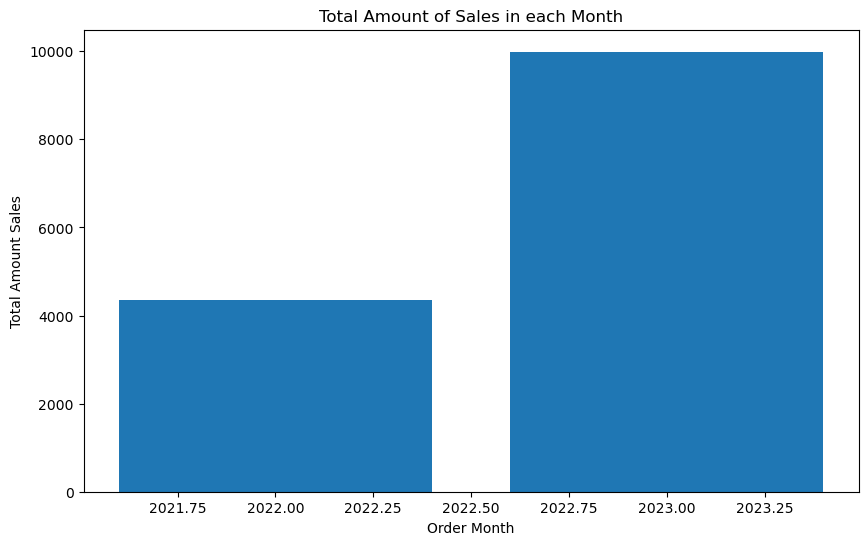

In [34]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
total_amount_sales_pd = Total_amount_sales.toPandas()

# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(total_amount_sales_pd['Order_year'], total_amount_sales_pd['Total_amount_sales'])
plt.xlabel('Order Month')
plt.ylabel('Total Amount Sales')
plt.title('Total Amount of Sales in each Month')

# Show the chart
plt.show()